# **Sarcasm Detection Using DistilBERT**

## **Introduction**

In this notebook, we fine-tune a pre-trained Transformer model (DistilBERT) to perform **sarcasm detection** on news headlines. The task is framed as a **binary text classification** problem—predicting whether a headline is sarcastic or not.

We use a labeled dataset containing news headlines with sarcasm labels. The overall workflow includes:

1. **Installing required libraries** using `pip`.
2. **Loading and preparing the dataset**, including sampling, splitting, and conversion to Hugging Face `Dataset` objects.
3. **Tokenizing the text data** using `DistilBERT` tokenizer with truncation and padding.
4. **Fine-tuning a pre-trained DistilBERT model** using Hugging Face’s `Trainer` API.
5. **Evaluating the model** on a held-out test set using metrics like accuracy, F1-score, and confusion matrix.
6. **Saving and reloading the trained model**, and testing it with custom examples using an inference function.

This notebook demonstrates a complete LLM-based sentiment classification pipeline and aligns with the objectives of Assignment 2 (7PAM2015), showing practical use of pre-trained models in fine-tuned applications.


# **Install Required Libraries**

In this cell, we uninstall any existing `transformers` version and reinstall the necessary packages using `pip`. These packages include:

- `transformers` for pre-trained language models (like DistilBERT)
- `datasets` for accessing and formatting datasets
- `evaluate` for model evaluation metrics
- `scikit-learn` for additional metrics like F1 and confusion matrix


In [ ]:
!pip uninstall -y transformers
!pip install --no-cache-dir transformers datasets evaluate scikit-learn


Found existing installation: transformers 4.53.0
Uninstalling transformers-4.53.0:
  Successfully uninstalled transformers-4.53.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 238.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 323.2 MB/s eta 0:00:00


# **Load and Prepare the Sarcasm Dataset**

We load a JSON dataset of headlines labeled for sarcasm. The following steps are performed:
- Rename `headline` to `text` and select only `text` and `label` columns.
- Sample 2,000 rows from the full dataset for quicker training.
- Split the dataset into training (80%), validation (10%), and test (10%) sets using stratified sampling.
- Convert all three splits into Hugging Face `Dataset` objects.


In [ ]:
# ✅ Load sarcasm dataset and prepare train/val/test split
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load JSON dataset
df = pd.read_json("https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json", lines=True)
df = df.rename(columns={"headline": "text", "is_sarcastic": "label"})
df = df[["text", "label"]]

# Reduce dataset size for faster training (optional)
df_small = df.sample(2000, random_state=42).reset_index(drop=True)

# Train/val/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_small["text"], df_small["label"], test_size=0.2, stratify=df_small["label"], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Convert to Hugging Face datasets
train_ds = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_ds   = Dataset.from_dict({"text": val_texts.tolist(),   "label": val_labels.tolist()})
test_ds  = Dataset.from_dict({"text": test_texts.tolist(),  "label": test_labels.tolist()})


# **Tokenize Text Using DistilBERT Tokenizer**

Here, we load the `distilbert-base-uncased` tokenizer and define a `tokenize()` function that:
- Applies truncation and padding
- Limits input sequence to 128 tokens
The function is applied to all train, validation, and test datasets using `.map()`.


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_tok = train_ds.map(tokenize, batched=True)
val_tok   = val_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

# **Load Pretrained Model and Define Evaluation Metrics**

We load the `distilbert-base-uncased` model for sequence classification with two output labels (sarcastic, not sarcastic).

We also define an evaluation function `compute_metrics()` that returns:
- Accuracy
- F1-score (weighted average)

These will be used during model training to monitor performance.


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# Load pretrained model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Metric function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }




model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Fine-Tune the Model with TrainingArguments and Trainer**

We configure `TrainingArguments` to specify:
- Number of epochs: 2
- Batch size: 16
- Evaluation strategy: once per epoch
- Best model selection based on F1 score

The Hugging Face `Trainer` API is used to fine-tune the model on the training set and validate on the validation set.


In [ ]:
from transformers import TrainingArguments ,Trainer

training_args = TrainingArguments(
    output_dir="./sarcasm_model",
    eval_strategy="epoch",  # WORKS with your current version
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=False,
    logging_steps=100,
    report_to="none"
)

print(" TrainingArguments initialized successfully.")
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


✅ TrainingArguments initialized successfully.


/tmp/ipython-input-5-651835280.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.434300,0.357654,0.860000,0.858889
2,0.143500,0.384911,0.875000,0.874344


TrainOutput(global_step=200, training_loss=0.28888927936553954, metrics={'train_runtime': 50.4856, 'train_samples_per_second': 63.384, 'train_steps_per_second': 3.962, 'total_flos': 105973918924800.0, 'train_loss': 0.28888927936553954, 'epoch': 2.0})

# **Evaluate Model Performance on Test Set**

We use the trained model to make predictions on the test dataset.

This cell:
- Computes and prints the classification report (precision, recall, F1-score)
- Displays the confusion matrix using `ConfusionMatrixDisplay` from `sklearn`
- Helps assess the model's ability to distinguish between sarcastic and non-sarcastic headlines


✅ Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.88      0.93      0.90       107
    Sarcastic       0.92      0.85      0.88        93

     accuracy                           0.90       200
    macro avg       0.90      0.89      0.89       200
 weighted avg       0.90      0.90      0.89       200

✅ Confusion Matrix:


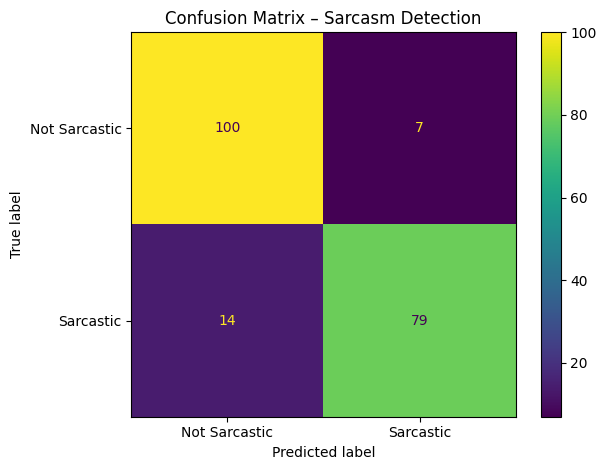

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
preds = trainer.predict(test_tok)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Report
print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Not Sarcastic", "Sarcastic"]))

# Confusion matrix
print(" Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Not Sarcastic", "Sarcastic"])
plt.title("Confusion Matrix – Sarcasm Detection")
plt.tight_layout()
plt.show()


# **Save the Final Model and Tokenizer**

After training and evaluation, we save the fine-tuned model and tokenizer to disk for later use. This allows us to load them later without re-training.


In [ ]:
#  Save model and tokenizer
trainer.save_model("./sarcasm_model_final")
tokenizer.save_pretrained("./sarcasm_model_final")


('./sarcasm_model_final/tokenizer_config.json',
 './sarcasm_model_final/special_tokens_map.json',
 './sarcasm_model_final/vocab.txt',
 './sarcasm_model_final/added_tokens.json',
 './sarcasm_model_final/tokenizer.json')

#  **Reload Saved Model and Perform Inference**

In this final cell:
- The saved model is reloaded from disk
- An inference function `predict_sarcasm()` is defined
- This function takes raw text input, tokenizes it, and returns predictions
- Two sample sentences are tested to verify the model's ability to detect sarcasm


In [ ]:
from transformers import AutoModelForSequenceClassification
import torch


# Reload model
loaded_model = AutoModelForSequenceClassification.from_pretrained("./sarcasm_model_final")

# Inference function
def predict_sarcasm(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt").to(loaded_model.device)
    with torch.no_grad():
        logits = loaded_model(**inputs).logits
    preds = logits.argmax(-1).cpu().numpy()
    labels = ["Not Sarcastic", "Sarcastic"]
    return [labels[p] for p in preds]

# Try it!
predict_sarcasm([
    "Oh great, now it's raining just after I washed the car.",
    "I love spending time with my family on weekends."
])


['Not Sarcastic', 'Not Sarcastic']